# The Real code

In [1]:
using Random, Distributions, Plots, XLSX

In [2]:
### Initial functions to load lambda and mu from the ArrivalProfiles.xlsx

# Change the type to Float64 from Int and String for the loaded vectors
function type_change(v)
    v_ny = Vector{Float64}()
    for i in 1:length(v)
        if typeof(v[i]) == String
            push!(v_ny,parse(Float64,v[i]))
        elseif typeof(v[i]) == Int64
            push!(v_ny,float(v[i]))
        else
            push!(v_ny,v[i])
        end
    end
    return v_ny
end
# Dsktop : 
# C:/Users/rasmu/Desktop/OneDrive/OneDrive - Danmarks Tekniske Universitet/Decisions under uncertainty/Projekt/ArrivalProfiles.xlsx
## Laptop : 
# C:/Users/rasmu/OneDrive - Danmarks Tekniske Universitet/Onedrive/OneDrive - Danmarks Tekniske Universitet/Decisions under uncertainty/Projekt/ArrivalProfiles.xlsx

function load_arri(path="C:/Users/rasmu/OneDrive - Danmarks Tekniske Universitet/Onedrive/OneDrive - Danmarks Tekniske Universitet/Decisions under uncertainty/Projekt/ArrivalProfiles.xlsx")
    xf = XLSX.readxlsx(path) # Loading

    # Lambda is given as expected arrivals therefore inverse
    lambda_port = 1 ./ type_change(xf[1]["C2:Z2"])
    lambda_dtu = 1 ./ type_change(xf[1]["C3:Z3"])

    # Travel time
    mu_rammer_dtu = type_change(xf[1]["C7:Z7"])
    mu_rammer_port = type_change(xf[1]["C8:Z8"])

    return lambda_port, lambda_dtu, mu_rammer_dtu, mu_rammer_port
end


# Might not be just as fast as PriorityQueue but it is not that much behind
# Inserts a value at the spot it fits
function insert_and_sort!(vect::Vector, x)
    (splice!(vect, searchsorted(vect,x), [x]); vect) 
end


insert_and_sort! (generic function with 1 method)

In [3]:
struct Environment # The environment including arrival rates and travel rates
    lambda_dtu::Vector{Float64}  #arrival rate 1
    mu_rammer_dtu::Vector{Float64} #service rate 1
    lambda_port::Vector{Float64} # arrival rate 2
    mu_rammer_port::Vector{Float64} #service rate 2
    
    # loading the vectors from excel
    lambda_port, lambda_dtu, mu_rammer_dtu, mu_rammer_port = load_arri() # NEEDS the path to load the document from!
    Environment() = new(lambda_port, lambda_dtu, mu_rammer_dtu, mu_rammer_port)
end

mutable struct Stats # Vector including [Station 1, Station 2]
    n_cars::Vector{Int64} # Number of cars at the stations at any given time
    un_fullfilled::Vector{Int64} # Amount of times a customer arrives to an empty station
    fullfilled::Vector{Int64} # Amount of times a costumer arrives and gets a car
    empty_time::Vector{Float64} # The time any given station has 0 cars
    currently_empty::Vector{Bool} # Is the station empty
end

struct Balance
    desired::Array{Tuple{Int64,Int64},1}
    rebalance_times::Vector{Float64}
end


In [4]:

function time_change(e::Array{Tuple{Float64,String},1},day::Int64)
    # Switch day and reset index
    if k == 24
        global k = 0
        global day += 24
    end
    # Insert the next time change
    popfirst!(e)[1]
    insert_and_sort!(e,(k+day,"time_change"))

    # Change index for time
    global k += 1

end

function arrival_student(station::Int64,e::Array{Tuple{Float64,String},1},env::Environment,stat::Stats)
    
    # Insert next arrival based on previous arrival
    if station == 1
        insert_and_sort!(e,(rand(Exponential(env.lambda_dtu[k]))+e[1][1],"st1"))
    elseif station == 2
        insert_and_sort!(e,(rand(Exponential(env.lambda_port[k]))+e[1][1],"st2"))
    end

    if stat.currently_empty[station] == true # Student arrives at empty station. That is one unsatisfied costumer :(
        stat.un_fullfilled[station] += 1 
        popfirst!(e) 
        
    else # Costumer leaves station
        stat.n_cars[station] -= 1 # removing car from station
        stat.fullfilled[station] += 1 # one fullfilled request
        
        # Insert travel time based on arrival station
        if station == 1
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_port[k]))+e[1][1],"que_st2")) 
        elseif station == 2
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_dtu[k]))+e[1][1],"que_st1")) 
        end

        if stat.n_cars[station] == 0 # station becomes empty
            stat.empty_time[station] -= popfirst!(e)[1] # Empty station timer starts 
            stat.currently_empty[station] = true
        else
            popfirst!(e)
        end
    end 

end 

function arrival_vehicle(station::Int64,e::Array{Tuple{Float64,String},1},env::Environment,stat::Stats)

    if stat.currently_empty[station] == true # Arriving at an empty station
        stat.n_cars[station] += 1 # arrive
        stat.empty_time[station] += popfirst!(e)[1] # End empty timer
        stat.currently_empty[station] = false
    else
        stat.n_cars[station] += 1 # arrive
        popfirst!(e)
    end

end


function rebalancing(rebal::Balance,stat::Stats,env::Environment,e::Array{Tuple{Float64,String},1})
    # NEEDS Documentation and a serious debugging

    # This is slow, do it globally
    travel_count_1 = 0
    travel_count_2 = 0
    for i in 1:length(e)
       if e[i][2] == "que_st1"
           travel_count_1 += 1
       elseif e[i][2] == "que_st2"
           travel_count_2 += 1
       end
    end

    if travel_count_1 + stat.n_cars[1] >= rebal.desired[rebalance_action][1]
        if stat.n_cars[1] <= (travel_count_1 + stat.n_cars[1])-rebal.desired[rebalance_action][1] # Hmmm
            for i in 1:stat.n_cars[1]
                insert_and_sort!(e,(rand(Exponential(env.mu_rammer_port[k]))+e[1][1],"que_st2"))
                stat.n_cars[1] -= 1
            end 
            stat.currently_empty[1] = true
            stat.empty_time[1] -= e[1][1]
        else
            for i in 1:(travel_count_1 + stat.n_cars[1])-rebal.desired[rebalance_action][1]
                insert_and_sort!(e,(rand(Exponential(env.mu_rammer_port[k]))+e[1][1],"que_st2"))
                stat.n_cars[1] -= 1
            end
            
        end

    elseif travel_count_2 + stat.n_cars[2] > rebal.desired[rebalance_action][2]
        if stat.n_cars[2] <= (travel_count_2 + stat.n_cars[2])-rebal.desired[rebalance_action][2] # Hmmm
            for i in 1:stat.n_cars[2]
                insert_and_sort!(e,(rand(Exponential(env.mu_rammer_dtu[k]))+e[1][1],"que_st1"))
                stat.n_cars[2] -= 1
            end 
            stat.currently_empty[2] = true
            stat.empty_time[2] -= e[1][1]
        else
            for i in 1:(travel_count_2 + stat.n_cars[2])-rebal.desired[rebalance_action][2]
                insert_and_sort!(e,(rand(Exponential(env.mu_rammer_dtu[k]))+e[1][1],"que_st1"))
                stat.n_cars[2] -= 1
            end
        end
    else
        throw(ErrorException("Error in rebalance!"))

    end

    # Adding the next reblance event one day later
    insert_and_sort!(e,(24.0+popfirst!(e)[1],"rebalance"))


    if rebalance_action == length(rebal.desired)
        global rebalance_action = 1
    else
        global rebalance_action += 1
    end

end

# HVAD FUUUUCK

rebalancing (generic function with 1 method)

In [5]:
function sim(days_to_run::Int64,initial_n_cars::Vector{Int64}, rebal::Balance, env::Environment)
    ###########
    # For Graphs of vehicles
    graph_st1 = []
    graph_st2 = []
    time = []

    ###########
    # Initial Misc
    stat = Stats([initial_n_cars[1],initial_n_cars[2]],[0,0],[0,0],[0,0],[false,false])
    e = Array{Tuple{Float64,String},1}()
    runs = 0
    
    ###########
    # arrival and travel rates
    insert_and_sort!(e,(0.0,"time_change"))
    global k = 1
    global day = 0
    
    ###########
    # Arrivals
    insert_and_sort!(e,(rand(Exponential(env.lambda_dtu[k])),"st1"))
    insert_and_sort!(e,(rand(Exponential(env.lambda_port[k])),"st2"))
    
    ###########
    # Rebalance
    global rebalance_action = 1
    for i in 1:length(rebal.rebalance_times)
        insert_and_sort!(e,(rebal.rebalance_times[i],"rebalance"))
    end


    while e[1][1] <= days_to_run*24.0 && runs <= 100000
        load_type = e[1][2]
        if load_type == "st1"
            arrival_student(1,e,env,stat)
        elseif load_type == "st2"
            arrival_student(2,e,env,stat)
        elseif load_type == "que_st1"
            arrival_vehicle(1,e,env,stat)
        elseif load_type == "que_st2"
            arrival_vehicle(2,e,env,stat)
        elseif load_type == "time_change"
            time_change(e,day)
        elseif load_type == "rebalance"
            rebalancing(rebal,stat,env,e)
        else
            throw(ErrorException("Issue in the event type!"))
        end
        push!(graph_st1,stat.n_cars[1])
        push!(graph_st2,stat.n_cars[2])
        push!(time,e[1][1])
        runs += 1 # Checks the amount of events
    end
    
    # Make sure the empty timer stops at the end of the run
    if stat.currently_empty[1] == true
        stat.empty_time[1] += e[1][1]
    elseif stat.currently_empty[2] == true
        stat.empty_time[2] += e[1][1]
    end
    
    return stat.n_cars,stat.un_fullfilled,stat.fullfilled,stat.empty_time,runs,graph_st1,graph_st2,time
end

sim (generic function with 1 method)

### Testing

In [8]:

function main(initial_n_cars::Vector{Int64},days_to_run::Int64,n_of_runs::Int64,rebalance::Tuple{Vector{Tuple{Int64, Int64}}, Vector{Float64}})
    env = Environment()
    rebal = Balance(rebalance[1],rebalance[2])
    overview = []
    efficiancy_cars = []
    efficiancy_empty = []

    for i in 1:n_of_runs
        a = sim(days_to_run,initial_n_cars,rebal,env)
        overview = [overview;a]
        # NEeds final stats
    
        efficiancy_fullfilled = [a[3][1]/(a[3][1]+a[2][1]), a[3][2]/(a[3][2]+a[2][2]) ]
        efficiancy_emptytime = [a[4][1]/(days_to_run*24),a[4][2]/(days_to_run*24)]

        # print("Efficiancy percentage for station 1 is ")
        # printstyled(round(efficiancy_fullfilled[1]*100,digits=2),"%"; color=:blue)
        # print(" and ")
        # printstyled(round(efficiancy_fullfilled[2]*100,digits=2),"%"; color=:blue)
        # print(" for station 2. Percentage of time spent empty for station 1 is ")
        # printstyled(round(efficiancy_emptytime[1]*100,digits=2),"%"; color=:blue)
        # print(" and ")
        # printstyled(round(efficiancy_emptytime[2]*100,digits=2),"%"; color=:blue)
        # println(" for station 2.")
     
        if n_of_runs == 1
            global out = [a[6],a[7],a[8]]
        end

        efficiancy_cars = [efficiancy_cars; [efficiancy_fullfilled]]
        efficiancy_empty = [efficiancy_empty; [efficiancy_emptytime]]
    end

    return efficiancy_empty, efficiancy_cars
end

main (generic function with 1 method)

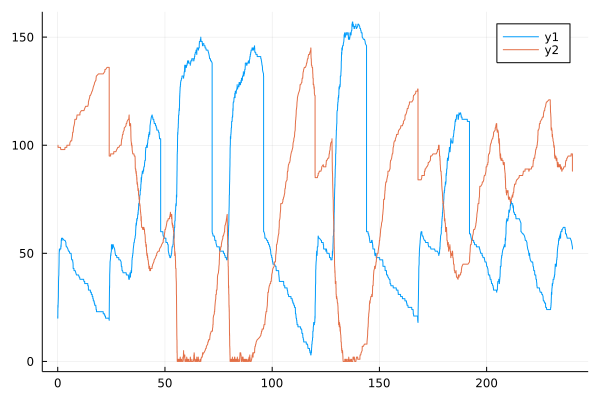

In [16]:
########### User manual ############
##### Inputs: main(1,2,3,4)
# 1: [initial cars at station 1, initial cars at station 2] (Int,Int)
# 2: days to run each simulation (Int)
# 3: Amount simulations to run (Int)
# 4: ( [(Desired amount at station 1 for first reblance, station 2 at first rebalance), (station 1 at second, station 2 at second), ..., (station 1 at n rebalance, station 2 at n)], [time of first rebalance, ..., time at n event] ) (Tuple(Int,Int),Float)


# rebal = Balance([(60,60),(60,60)],[0.0,12.0])
# env = Environment()

# sim(20,[80,80],rebal,env)


# main([50,50],100,20,([(90,10),(60,40)],[6.5,13.5]))
main([140,20],10,1,([(100,60)],[0.0]))

# Der er for mange unfullfilled for station 1
# Empty time for station 2 er for høj relativt til station 1



plot(out[3],out[2])
plot!(out[3],out[1])

In [ ]:
# Tjekker start distribution, virker som om den er stortset irrelevant

effic_st1 = []
effic_st2 = []
position = []
for n in 60:60
    for i in 1:10:(n-1)
        _, effic = main([i,n-i],100,n, ([(100,20),(40,80)],[7.0,13.0]) )
        total_effic = [effic[1][1],effic[1][2]]
        for j in 2:n
            total_effic = [effic[j][1]+total_effic[1],effic[j][2]+total_effic[2]]
        end
        
        push!(effic_st1,total_effic[1]/n)
        push!(effic_st2,total_effic[2]/n)
        push!(position,[i,n-i,n])

    end
end

println(findmax(effic_st1)," for station1")
println(findmax(effic_st2)," for station2")
println(position[findmax(effic_st1)[2]]," for station1")
println(position[findmax(effic_st2)[2]]," for station2")


In [71]:
# Only rebalance amount
effic_st1 = []
effic_st2 = []
position = []
n = 80


for j in 1:15:n*2
    _, effic = main([n,n],100,30, ([(j,n*2-j)],[0.0]) )
    total_effic = [effic[1][1],effic[1][2]]
    for p in 2:30-1
        total_effic = [effic[p][1]+total_effic[1],effic[p][2]+total_effic[2]]
    end
    
    push!(effic_st1,total_effic[1]/30)
    push!(effic_st2,total_effic[2]/30)
    push!(position,[j,n*2-j])
end

total_effic = effic_st1 .+ effic_st2
a = findmax(total_effic)[2]

# println(findmax(effic_st1)," for station1")
# println(findmax(effic_st2)," for station2")
# println(position[findmax(effic_st1)[2]]," for station1")
# println(position[findmax(effic_st2)[2]]," for station2")

println("Efficiancy:\nstation1 ",effic_st1[a],"\nstation2: ",effic_st2[a],"\nposition: ",position[a])



Efficiancy:
station1 0.7388815796603638
station2: 0.932562613583956
position: [121, 39]


In [83]:
# Only rebalance amount
effic_st1 = []
effic_st2 = []
position_reb1 = []
position_reb2 = []
n = 80

for i in 1:20:n*2
    for j in 1:20:n*2
        _, effic = main([n,n],100,30, ([(j,n*2-j),(i,n*2-i)],[7.0,13.0]) )
        total_effic = [effic[1][1],effic[1][2]]
        for p in 2:30-1
            total_effic = [effic[p][1]+total_effic[1],effic[p][2]+total_effic[2]]
        end
        
        push!(effic_st1,total_effic[1]/30)
        push!(effic_st2,total_effic[2]/30)
        push!(position_reb1,[j,n*2-j])
        push!(position_reb2,[i,n*2-i])
    end
end

total_effic = effic_st1 .+ effic_st2
a = findmax(total_effic)[2]

# println(findmax(effic_st1)," for station1")
# println(findmax(effic_st2)," for station2")
# println(position[findmax(effic_st1)[2]]," for station1")
# println(position[findmax(effic_st2)[2]]," for station2")

println("Efficiancy:\nstation1 ",effic_st1[a],"\nstation2: ",effic_st2[a],"\nposition_reb1: ",position_reb1[a],"\nposition_reb2: ",position_reb2[a])


Efficiancy:
station1 0.9503369226403363
station2: 0.9663418480228486
position_reb1: [141, 19]
position_reb2: [101, 59]


In [82]:
effic_st1 = []
effic_st2 = []
time_reb1 = []
time_reb2 = []
n = 80

for i in 1:24
    for j in 1:24
        _, effic = main([n,n],50,30, ([(141,19),(61,99)],[float(i),float(j)]) )
        total_effic = [effic[1][1],effic[1][2]]
        for p in 2:30-1
            total_effic = [effic[p][1]+total_effic[1],effic[p][2]+total_effic[2]]
        end
        
        push!(effic_st1,total_effic[1]/30)
        push!(effic_st2,total_effic[2]/30)
        push!(time_reb1,[i])
        push!(time_reb2,[j])
    end
end

total_effic = effic_st1 .+ effic_st2
a = findmax(total_effic)[2]

# println(findmax(effic_st1)," for station1")
# println(findmax(effic_st2)," for station2")
# println(position[findmax(effic_st1)[2]]," for station1")
# println(position[findmax(effic_st2)[2]]," for station2")

println("Efficiancy:\nstation1 ",effic_st1[a],"\nstation2: ",effic_st2[a],"\ntime 1: ",time_reb1[a],"\ntime 2: ",time_reb2[a])

Efficiancy:
station1 0.9435566330994689
station2: 0.9662759568378154
time 1: [7]
time 2: [13]


## Redundant


In [165]:
function sim_uden_rebalance(days_to_run::Int64,initial_n_cars::Vector{Int64}, env::Environment)

    ###########
    # Initial Misc
    stat = Stats([initial_n_cars[1],initial_n_cars[2]],[0,0],[0,0],[0,0],[false,false])
    e = Array{Tuple{Float64,String},1}()
    runs = 0
    
    ###########
    # arrival and travel rates
    insert_and_sort!(e,(0.0,"time_change")) # THIS NEEDS TO BE FIXED!!!!!!!!
    global k = 1
    global day = 0
    
    ###########
    # Arrivals
    insert_and_sort!(e,(rand(Exponential(env.lambda_dtu[k])),"st1"))
    insert_and_sort!(e,(rand(Exponential(env.lambda_port[k])),"st2"))


    while e[1][1] <= days_to_run*24.0 && runs <= 100000
        load_type = e[1][2]
        if load_type == "st1"
            arrival_student(1,e,env,stat)
        elseif load_type == "st2"
            arrival_student(2,e,env,stat)
        elseif load_type == "que_st1"
            arrival_vehicle(1,e,env,stat)
        elseif load_type == "que_st2"
            arrival_vehicle(2,e,env,stat)
        elseif load_type == "time_change"
            time_change(e,day)
        else
            throw(ErrorException("Issue in the event type!"))
        end
        runs += 1 # Checks the amount of events
    end
    
    # Make sure the empty timer stops at the end of the run
    if stat.currently_empty[1] == true
        stat.empty_time[1] += e[1][1]
    elseif stat.currently_empty[2] == true
        stat.empty_time[2] += e[1][1]
    end
    
    return stat.n_cars,stat.un_fullfilled,stat.fullfilled,stat.empty_time,runs
end

sim_uden_rebalance (generic function with 1 method)

In [188]:
sim_uden_rebalance(20,[30,30],Environment())

([2, 56], [1600, 136], [833, 807], [127.3369999523511, 68.93927664246212], 5495)

In [ ]:

    if stat.n_cars[1] >= rebal.desired[rebalance_action][2]
        for i in 1:rebal.desired[rebalance_action][1]
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_dtu[k]))+e[1][1],"que_st1")) 
            stat.n_cars[2] -= 1
        end
        
        # Start empty timer
        if stat.n_cars[2] == 0
            stat.empty_time[2] -= e[1][1]
            stat.currently_empty[2] = true
        end

    else
        for i in 1:stat.n_cars[2]
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_dtu[k]))+e[1][1],"que_st1"))
            stat.n_cars[2] -= 1
        end
        if stat.currently_empty[2] == false
            stat.empty_time[2] -= e[1][1]
            stat.currently_empty[2] = true
        end
    end

    # For station 1
    if stat.n_cars[1] >= rebal.desired[rebalance_action][2]
        for i in 1:rebal.desired[rebalance_action][2]
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_port[k]))+e[1][1],"que_st2"))
            stat.n_cars[1] -= 1
        end
        
        # Start empty timer
        if stat.n_cars[1] == 0
            stat.empty_time[1] -= e[1][1]
            stat.currently_empty[1] = true
        end
    else
        for i in 1:stat.n_cars[1]
            insert_and_sort!(e,(rand(Exponential(env.mu_rammer_port[k]))+e[1][1],"que_st2"))
            stat.n_cars[1] -= 1
        end
        if stat.currently_empty[1] == false
            stat.empty_time[1] -= e[1][1]
            stat.currently_empty[1] = true
        end
    end 

    insert_and_sort!(e,(24.0+popfirst!(e)[1],"rebalance"))

    # Virkelig grim måde at gøre det på 
    if rebalance_action == length(rebal.desired)
        rebalance_action = 1
    else
        rebalance_action += 1
    end